# Обучение простой модели классификации слов
На вход подается набор картинок букв, на выход вектор из трех чисел:(abc)
- a равно 1 если шрифт с засечкой, иначе 0
- b равно 1 если шрифт пропорциональный, иначе если моно, то 0
- с равен 0 если шрифт тонкий, 0.5 если шрифт обычный и 1 если шрифт жирный

Шрифты отрисовываются разными цветами, разным размером (но сжимается), смещением

Исходных шрифтов 12 (2 вида засечки $\times$ 2 вида пропорции $\times$ 3 вида толщины)


In [227]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random
import os
from itertools import product
import torch
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn
from torch import optim
import numpy as np 
import cv2

**Необходимое для получения изображений**

In [100]:


russian_letters = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'

SIZE_IMAGE = (30, 40) # ширина и высота
FONT_SIZE = 40 # размер шрифта
INTRERVAL = [
    (-10, 10), # отклонение по ширине
    (-20, 5) # отклонение по высоте
]

FONTS = {
    "000": "font/000_roboto-mono.ttf",
    "001": "font/001_roboto-mono.ttf",
    "002": "font/002_roboto-mono.ttf",
    "010": "font/010_AA Stetica.ttf",
    "011": "font/011_AA Stetica.ttf",
    "012": "font/012_AA Stetica.ttf",
    "100": "font/100_couriermot.otf",
    "101": "font/101_Courier.ttf",
    "102": "font/102_Courier.ttf",
    "110": "font/110_Spectral.ttf",
    "111": "font/111_Spectral.otf",
    "112": "font/112_Spectral.ttf",
}

def random_position_with_constraints():
    """
    Генерирует случайную позицию с ограничениями из массива INTERVAL.
    
    :param interval: Массив вида [(min_x, max_x), (min_y, max_y)].
    :return: Кортеж (x, y) — случайная позиция.
    """
    # Разделяем интервалы для ширины (x) и высоты (y)
    x_interval, y_interval = INTRERVAL
    
    # Генерация случайной позиции по ширине (x)
    x = random.randint(x_interval[0], x_interval[1])
    
    # Генерация случайной позиции по высоте (y)
    y = random.randint(y_interval[0], y_interval[1])
    
    return (x, y)

def random_russian_letter():
    # Возвращаем случайную букву
    return random.choice(russian_letters)

def random_saturated_color(backcolor=False):
    # Генерация случайных значений для R, G, B
    r = random.randint(0, 127)
    g = random.randint(0, 127)
    b = random.randint(0, 127)
    
    # Убедимся, что хотя бы один канал близок к 0, а другой — к 127
    if max(r, g, b) - min(r, g, b) < 50:  # Если цвета слишком близки (серый)
        # Перегенерируем один из каналов
        if random.choice([True, False]):
            r = random.choice([0, 127])
        else:
            g = random.choice([0, 127])
    
    return (r, g, b) if not backcolor else (255-r//4, 255-g//4, 255-b//4)

def get_random_char_image(font_path):
    backcolor = random_saturated_color(backcolor=True)
    textcolor = random_saturated_color()
    position = random_position_with_constraints()
    text = random_russian_letter()
    
    image = Image.new('RGB', SIZE_IMAGE, color=backcolor)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, FONT_SIZE)

    draw.text(position, text, font=font, fill=textcolor)
    return image

**пример изображения**

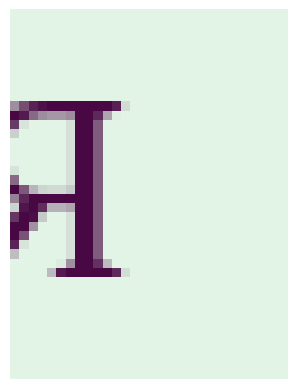

In [101]:
image = get_random_char_image(FONTS["110"])

# Отображаем изображение с помощью matplotlib
plt.imshow(image)
plt.axis('off')  # Скрываем оси
plt.show()

In [105]:
def generate_dataset(output_dir="dataset", num_samples=1000):
    """
    Генерирует набор данных из изображений для всех возможных комбинаций из 3 цифр кода шрифта.
    
    :param output_dir: Папка для сохранения данных.
    :param num_samples: Количество изображений для каждой комбинации.
    """
    # Создаем папку для набора данных, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        raise Exception("Такая папка уже существует!")
        return
    
    # Все возможные значения для каждой цифры
    digits = [
        [0, 1],  # Первая цифра
        [0, 1],  # Вторая цифра
        [0, 1, 2]  # Третья цифра
    ]
    
    # Генерация всех возможных комбинаций
    combinations = list(product(*digits))
    
    # Для каждой комбинации генерируем num_samples изображений
    for combo in combinations:
        font_name = f"{combo[0]}{combo[1]}{combo[2]}"
        # Создаем папку для комбинации
        combo_dir = os.path.join(output_dir, font_name)
        if not os.path.exists(combo_dir):
            os.makedirs(combo_dir)
        
        # Генерация изображений
        for i in range(num_samples):
            # Получаем изображение
            image = get_random_char_image(FONTS[font_name])
            
            # Сохраняем изображение
            image_path = os.path.join(combo_dir, f"image_{i}.png")
            image.save(image_path)
    
    print(f"Набор данных успешно создан в папке {output_dir}")

In [107]:
# Создание датасета
generate_dataset()

Набор данных успешно создан в папке dataset


### Датасет в PyTorch

In [193]:
class CharImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.labels = sorted(os.listdir(self.img_dir))
        self.counts = [len(os.listdir(os.path.join(self.img_dir, label))) for label in self.labels]
        self.count = sum(self.counts)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        label, i = self.__get_label_and_i_from_idx(idx)
        img_path = os.path.join(self.img_dir, label, f"image_{i}.png")
        image = Image.open(img_path)
        image_array = np.array(image)
        
        if self.transform:
            image_array = self.transform(image_array)
        if self.target_transform:
            label = self.target_transform(label)
        return image_array, label

    def __get_label_and_i_from_idx(self, idx):
        k = 0
        while (idx - self.counts[k]) >= 0:
            idx -= self.counts[k]
            k += 1
        return self.labels[k], idx
            
            
def label_to_vec(text):
    return torch.Tensor([float(text[0]),float(text[1]), float(text[2])])

def image_to_gray(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)/255
    return torch.Tensor([grayscale_image])

In [194]:
dataset = CharImageDataset("dataset/", transform=image_to_gray, target_transform=label_to_vec)

tensor([0., 0., 0.])
tensor([0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255,
        0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255,
        0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255, 0.9255,
        0.9255, 0.9255, 0.9255])


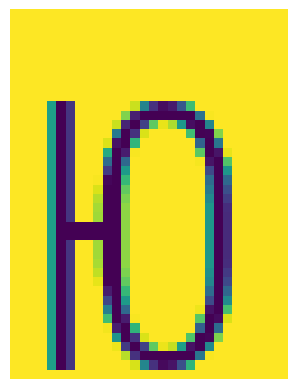

In [195]:
image, label = dataset[3]
print(label)
print(image[0][0])
plt.imshow(image[0])  # [] - для выделения канала, тут только ч/б
plt.axis('off')  # Скрываем оси
plt.show()

In [224]:
class CharCNNClassifier(nn.Module):
    def __init__(self):
        super(CharCNNClassifier, self).__init__()
        
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Максимальный пулинг
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(32 * 10 * 7, 128)  # После пулинга размер изображения уменьшается
        self.fc2 = nn.Linear(128, 3)  # Выходной вектор длины 3
        
        # Функция активации
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Применяем свертки и пулинг
        x = self.pool(self.relu(self.conv1(x)))  # Размер: (batch_size, 16, 20, 15) <- размер уменьшился в 2 раза
        x = self.pool(self.relu(self.conv2(x)))  # Размер: (batch_size, 32, 10, 7) <- размер уменьшился в 2 раза
        
        # Выравниваем тензор для полносвязного слоя
        x = x.view(x.size(0), -1)  # Размер: (batch_size, 32 * 10 * 7)
        
        # Применяем полносвязные слои
        x = self.relu(self.fc1(x))  # Размер: (batch_size, 128)
        x = self.fc2(x)  # Размер: (batch_size, 3)
        
        return x

# Создаем модель
model = CharCNNClassifier()

example_batch_x = torch.Tensor([dataset[i][0].numpy() for i in range(10)])
example_batch_y = torch.Tensor([dataset[i][1].numpy() for i in range(10)])
# Пропускаем изображение через модель
output = model(example_batch_x)
print(output)
print(example_batch_y)

tensor([[ 0.0663,  0.0057,  0.0925],
        [ 0.0646, -0.0029,  0.0759],
        [ 0.0580, -0.0015,  0.0990],
        [ 0.0736,  0.0056,  0.0837],
        [ 0.0625,  0.0044,  0.0909],
        [ 0.0669,  0.0077,  0.0888],
        [ 0.0641,  0.0047,  0.0962],
        [ 0.0628,  0.0007,  0.0958],
        [ 0.0724,  0.0040,  0.0932],
        [ 0.0727,  0.0074,  0.0836]], grad_fn=<AddmmBackward0>)
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [231]:
EPOCHS = 100

model = CharCNNClassifier()
criterion = nn.MSELoss()  # Функция потерь для регрессии
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор
train = DataLoader(dataset, batch_size=128, shuffle=True)
for epoch in range(EPOCHS):
    model.train()  # Переводим модель в режим обучения
    running_loss = 0.0

    for i, (inputs, targets) in enumerate(train):
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs)

        # Вычисление потерь
        loss = criterion(outputs, targets)

        # Обратное распространение и обновление весов
        loss.backward()
        optimizer.step()

        # Суммируем потери для вывода
        running_loss += loss.item()

        # Выводим статистику каждые 10 батчей
        if i % 10 == 9:
            print(f"Epoch [{epoch + 1}/{EPOCHS}], Batch [{i + 1}/{len(train)}], Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

Epoch [1/100], Batch [10/94], Loss: 0.5002
Epoch [1/100], Batch [20/94], Loss: 0.3839
Epoch [1/100], Batch [30/94], Loss: 0.3593
Epoch [1/100], Batch [40/94], Loss: 0.3167
Epoch [1/100], Batch [50/94], Loss: 0.2935
Epoch [1/100], Batch [60/94], Loss: 0.2753
Epoch [1/100], Batch [70/94], Loss: 0.2617
Epoch [1/100], Batch [80/94], Loss: 0.2503
Epoch [1/100], Batch [90/94], Loss: 0.2391
Epoch [2/100], Batch [10/94], Loss: 0.2309
Epoch [2/100], Batch [20/94], Loss: 0.2238
Epoch [2/100], Batch [30/94], Loss: 0.2202
Epoch [2/100], Batch [40/94], Loss: 0.2105
Epoch [2/100], Batch [50/94], Loss: 0.2174
Epoch [2/100], Batch [60/94], Loss: 0.2138
Epoch [2/100], Batch [70/94], Loss: 0.2044
Epoch [2/100], Batch [80/94], Loss: 0.2032
Epoch [2/100], Batch [90/94], Loss: 0.2008
Epoch [3/100], Batch [10/94], Loss: 0.1957
Epoch [3/100], Batch [20/94], Loss: 0.1994
Epoch [3/100], Batch [30/94], Loss: 0.1997
Epoch [3/100], Batch [40/94], Loss: 0.1876
Epoch [3/100], Batch [50/94], Loss: 0.1824
Epoch [3/10

In [233]:
# Простая проверка модели

In [296]:
def get_image_from_text(font_path, text):
    backcolor = random_saturated_color(backcolor=True)
    textcolor = random_saturated_color()

    n = len(text)
    image = Image.new('RGB', (FONT_SIZE*4*n//5, FONT_SIZE), color=backcolor)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, FONT_SIZE)

    draw.text((0, 0), text, font=font, fill=textcolor)
    return image

def classifier(model, chars):
    grays = [image_to_gray(char).numpy() for char in chars]
    data = torch.Tensor(grays)
    rez = model(data)
    return torch.mean(rez, 0)

def interpretation_class(class_):
    if class_[0] > 0.5:
        print("Засечки: есть")
    else:
        print("Засечки: нет")

    if class_[1] > 0.5:
        print("Моно: нет")
    else:
        print("Моно: да")

    if class_[2] > 1.5:
        print("Начертание: жирный")
    elif class_[2] > 0.5:
        print("Начертание: обычный")
    else:
        print("Начертание: тонкий")

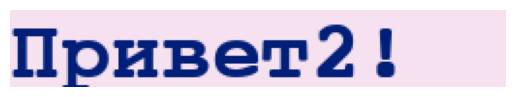

tensor([0.8219, 0.3149, 1.8320], grad_fn=<MeanBackward1>)
Засечки: есть
Моно: да
Начертание: жирный


In [317]:
image = get_image_from_text(FONTS["102"], "Привет2!")

# Отображаем изображение с помощью matplotlib
plt.imshow(image)
plt.axis('off')  # Скрываем оси
plt.show()

image_array = np.array(image)
chars = [image_array[:, i*30:(i+1)*30, :]for i in range(image_array.shape[1]//30)]

class_ = classifier(model, chars)
print(class_)
interpretation_class(class_)

In [318]:
torch.save(model.state_dict(), "font_classifier_model")